In [1]:
#import libraties 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from textblob import TextBlob
%matplotlib inline 

In [2]:
#reading data
train_tweets =pd.read_csv('./data/train_tweets.csv') 
test_tweets = pd.read_csv('./data/test_tweets.csv')

In [3]:
train_tweets.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
test_tweets.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [5]:
print('train_tweets shape :{} , label 0:{} ,label 1 :{}' .format(
train_tweets.shape , 
train_tweets[train_tweets['label']==0].count()['label'],
train_tweets[train_tweets['label']==1].count()['label']

))

train_tweets shape :(31962, 3) , label 0:29720 ,label 1 :2242



Let’s visualize this data in countplot between the labels with seaborn library. We have only 2242 positive tweets only while 29720 negative tweets. It looks so imbalanced. We have to tackle this problem before processing the data. You wonder why is it a problem?

Let’s say we have a machine learning model to classify everything (every tweet) as negative the label 0 in this data, then this classifier seems understanding most of sentiments in tweet texts because most of data are negative in this circumstance.

<AxesSubplot:xlabel='label', ylabel='count'>

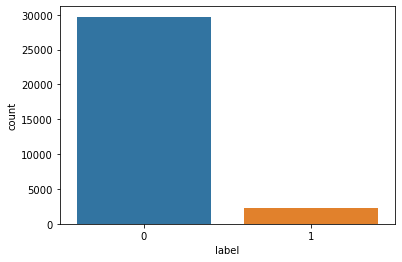

In [6]:
sns.countplot(x = 'label', data = train_tweets)

To cope with imbalanced data, I choose one of the oversampling methods to generate synthetic samples in the label 1. As a result, the number of label 1 will increase to 29720 that is the same amout of the negative label. But I don’t do that process before preprocessing and convert the tweets to features.

 process documents and sentences, feature engineering?
We’ve got raw tweets so we need to do preprocessing and vectorize the instances for algorithm to understand and learn patterns. Here are 5 sub-sections I will follow for data processing and feature engineering.

Removal of punctuations
Removal of commonly used words (stopwords)
Lemmatization
Vectorization
Oversampling (SMOTE)

Removal of punctuations such as %, hashtag #, and @ in tweet is the first step and the second we can remove the frequent used words (stopwords) and at last we will lemmatize the words in the lists. As a result we will be able to have clean lists of lemmatized words without any distractions such as punctuations and stopwords. Let’s pack these 3 features in 1 function with an argument (a raw tweet). We use NLTK library for this purpose. Here’s the sample code. I used TextBlob to remove punctuations.

In [7]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/mohammedessam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/mohammedessam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mohammedessam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
def preprocessing (tweet) :
    # Generating the list of words in the tweet (hastags and other punctuations removed)
    def from_sentence(tweet):
        tweet_blob = TextBlob(tweet)
        return ' '.join(tweet_blob.words)
    
    #removing stopwords and words with unusual symbols 
    def no_user_alpha (tweet):
        tweet_list = [ele for ele in tweet.split() if ele != 'user']
        clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$',t)]
        clean_s = ' '.join(clean_tokens)
        clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english') ]
        return clean_mess
    
    # Lemmatize the words in tweets 
    def lemmatization (tweet_list):
        lem = WordNetLemmatizer()
        lemmatized_tweet = []
        for word in tweet_list :
            lemmatized_text = lem.lemmatize(word, 'v')
            lemmatized_tweet.append(lemmatized_text)
        return lemmatized_tweet
    
    new_tweet = from_sentence(tweet)
    no_punc_tweet = no_user_alpha(new_tweet)
    lemmatized_tweet = lemmatization(no_punc_tweet)
    
    return lemmatized_tweet
        

Let’s see how it works with the sample. Print the 10th item of train data in Python interpreter, then next print the preprocessed 10th item, how does it look like? We don’t see punctuations % and #, no stopwords such as in and to in the original tweet. Also unfamilier characters have been removed from the sentence. Sweet.

In [9]:
print (train_tweets['tweet'].iloc[10])

 â #ireland consumer price index (mom) climbed from previous 0.2% to 0.5% in may   #blog #silver #gold #forex


In [10]:
print (preprocessing(train_tweets['tweet'].iloc[10]))

['ireland', 'consumer', 'price', 'index', 'mom', 'climb', 'previous', 'may', 'blog', 'silver', 'gold', 'forex']


Let’s move to vectorize the lemmatized tweets. Why vectorize? Because machine learning algorithms can understand only numeric values, so words in string, sentences in text, categorical data must be preprocessed into numbers in advance to train in machine learning algorithms. There are 3 major vectorizing ways for text 1) Frequency Vectors, 2) One-hot encoding, 3) Tfidf Vectors. Let’s use TfidfVectorizer in scikit-learn library.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
"""
min_df=2, discard words appearing in less than 2 documents
max_df=0.9, discard words appering in more than 90% of the documents
sublinear_tf=True, use sublinear weighting
use_idf=True, enable IDF
"""

vec = TfidfVectorizer(
    analyzer = preprocessing,
    min_df = 2 ,
    max_df = 0.9,
    sublinear_tf = True,
    use_idf = True
)
train_vec = vec.fit_transform(train_tweets['tweet'])


We’ve got vectorized train data now. It’s time to apply SMOTE to oversample the positive tweets to the same level of the negative tweets. Recall that we have only 2242 positive tweets compared to 29720 negative tweets.

In [16]:
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

In [22]:
X = train_vec
y = train_tweets['label']
print('X shape: {}, y shape: {}'.format(X.shape, y.shape))

sm = SMOTE(sampling_strategy='auto', random_state=39)
X_resampled, y_resampled = sm.fit_resample(X, y)
print('Resampled label balance:\n{}'.format(y_resampled.value_counts()))

X shape: (31962, 12055), y shape: (31962,)
Resampled label balance:
0    29720
1    29720
Name: label, dtype: int64


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report ,confusion_matrix,accuracy_score

x_train ,x_test, y_train,y_test = train_test_split(X_resampled,y_resampled,test_size=0.33, random_state=39)
print('X_train shape: {}'.format(x_train.shape))
print('X_test shape: {}'.format(x_test.shape))
print('y_train shape: {}'.format(y_train.shape))
print('y_test shape: {}'.format(y_test.shape))

# pick three algorithms Multinomial Naive Bayes, RandomForest and GradientBoosting
from sklearn.naive_bayes import MultinomialNB 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

clf_mnb =MultinomialNB()
clf_rfc =RandomForestClassifier(random_state=39)
clf_gbc =GradientBoostingClassifier(random_state=39)
clf_names =['MultinomialNB', 'RandomForest', 'GradientBoosting']
clf_types=[clf_mnb,clf_rfc,clf_gbc]

for i ,clf in enumerate (clf_types):
    clf.fit(x_train,y_train.values.ravel())
    print('Result of {}\n'.format(clf_names[i]))
    predictions = clf.predict(x_test)
    print(classification_report(predictions, y_test))
    print('\n')
    print('Confusion matrix: \n', confusion_matrix(predictions, y_test))
    print('\n')
    print('Accuracy score: ', accuracy_score(predictions, y_test))
    print('\n\n\n')


X_train shape: (39824, 12055)
X_test shape: (19616, 12055)
y_train shape: (39824,)
y_test shape: (19616,)
Result of MultinomialNB

              precision    recall  f1-score   support

           0       0.92      0.95      0.93      9550
           1       0.95      0.92      0.93     10066

    accuracy                           0.93     19616
   macro avg       0.93      0.93      0.93     19616
weighted avg       0.93      0.93      0.93     19616



Confusion matrix: 
 [[9044  506]
 [ 820 9246]]


Accuracy score:  0.9324021207177814




Result of RandomForest

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      9655
           1       0.99      0.97      0.98      9961

    accuracy                           0.98     19616
   macro avg       0.98      0.98      0.98     19616
weighted avg       0.98      0.98      0.98     19616



Confusion matrix: 
 [[9549  106]
 [ 315 9646]]


Accuracy score:  0.9785379282218597




Result of

(Optional) Test the generated model
It’s time to play with real world data. I pick 2 Donald Trump’s tweets from his timeline. Let’s use our model to predict tweet’s polarity whether it is positive or negative from vectorized words.

We are providing better care, and more choice, at lower cost. We are delivering a healthier, safer, brighter, and more prosperous future for EVERY citizen in our magnificent land – because we are proudly putting AMERICA FIRST! pic.twitter.com/DgeDlpizk1

In [33]:
tweet = 'We are providing better care, and more choice, at lower cost. We are delivering a healthier, safer, brighter, and more prosperous future for EVERY citizen in our magnificent land – because we are proudly putting AMERICA FIRST!'
preprocess_tweet = preprocessing(tweet)
print(preprocess_tweet)

['provide', 'better', 'care', 'choice', 'lower', 'cost', 'deliver', 'healthier', 'safer', 'brighter', 'prosperous', 'future', 'EVERY', 'citizen', 'magnificent', 'land', 'proudly', 'put', 'AMERICA', 'FIRST']


In [35]:
# vectorize the tweet
tweet_vec = vec.transform(pd.Series([tweet]))
# predict a label
tweet_prediction = clf_rfc.predict(tweet_vec.toarray())
tweet_prediction = 'positive' if tweet_prediction[0] == '1' else 'negative'
print('{} has been predicted for the tweet {}'.format(tweet_prediction, tweet))

negative has been predicted for the tweet We are providing better care, and more choice, at lower cost. We are delivering a healthier, safer, brighter, and more prosperous future for EVERY citizen in our magnificent land – because we are proudly putting AMERICA FIRST!
